In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import json
import os
import numpy as np
import cv2


In [2]:
# to avoid the memory error, this function is created to load the data in chunks
def json_chunks(file_path, chunksize=10000):
    chunks = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for chunk in pd.read_json(file, lines=True, chunksize=chunksize):
            chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

In [4]:
# Loading the photos dataset
df_photo = json_chunks('C:/Users/singh/Downloads/yelp_dataset/photos.json', chunksize=10000)

In [5]:
df_photo.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [6]:
df_photo.info

<bound method DataFrame.info of                       photo_id             business_id  \
0       zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1       HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2       vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3       pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4       H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   
...                        ...                     ...   
200095  4Zia9NkAfQNjMfcIDhwJ-g  2HxkdqHmbYGj_BH1bLaiSw   
200096  KB96KRZRhRm8hUkI-OpGEA  _gVyuTRb_6HM-SNtqbpevQ   
200097  Klmojvaf2_2dP1XKzTsFmQ  NUyEOjfAl3HvkpzSpdwqeA   
200098  FNEiq7Mogec7t31OaU5juw  hE6YsHHV0fCz_UrGS4o6VA   
200099  NHEtLh7APk7Yssjo0h45VA  VIYvcX9SScnqmoI0so1KZA   

                                                  caption    label  
0       Nice rock artwork everywhere and craploads of ...   inside  
1                                                          outside  
2                                          oyster shooter    dri

In [7]:
df_photo.shape

(200100, 4)

In [8]:
df_photo.describe(include= 'all')

,photo_id,business_id,caption,label
count,200100,200100,200100,200100
unique,200098,36680,76413,5
top,_CYoxbCIKuAwpq4crHCPWg,FEXhWNCMkv22qG04E83Qjg,,food
freq,2,528,103366,108152


# Image Preprocessing


In [9]:
# looking for the missing values in the data
missing_values = df_photo.isnull().sum()
print("missing values are:\n", missing_values)
print("\n                            There are no missing values in the dataset")

missing values are:
 photo_id       0
business_id    0
caption        0
label          0
dtype: int64

                            There are no missing values in the dataset


In [10]:
 # Checking for the duplicate values
duplicate = df_photo.duplicated().sum()
print("No. of duplicate are:", duplicate)
print("\n                                There are no duplicate values")

No. of duplicate are: 0

                                There are no duplicate values


In [13]:

# defining the paths of photos
input_dir = r'C:/Users/singh/Downloads/yelp_dataset/photos'  
output_dir = r'C:/Users/singh/Downloads/yelp_dataset/photos/Processed'  

# creating the output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# set the size of images
new_img_size = (224, 224)    # resizing the photos to 224 x 224 pixels


# setting the limit to process photos
processed_img_count = 0
max_process_limit = 10000  # only 10000 images will be processed

for filename in os.listdir(input_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # cheking the format of photos
        img_path = os.path.join(input_dir, filename)

        try:
            # read photos using opencv
            img = cv2.imread(img_path)

            # ensuring if the image is loaded correctly or not
            if img is None:
                print(f"Error reading {filename}: Unsupported format or image not found .")
                continue
            
            # check if image type is float32 for mean subtraction and normalization
            img = img.astype(np.float32) / 255.0 

            # resizing images
            resized_img = cv2.resize(img, new_img_size)

            # normalizing images
            norm_img = resized_img  

            # grayscale conversion of images
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

            # mean subtraction of images
            mean = np.mean(norm_img, axis=(0, 1))
            mean_sub_img = norm_img - mean

            # cropping images
            h, w = resized_img.shape[:2]
            crop_size = min(h, w)
            start_x = w // 2 - crop_size // 2
            start_y = h // 2 - crop_size // 2
            crop_img = resized_img[start_y:start_y + crop_size, start_x:start_x + crop_size]

            #  histogram equalization of images
            hist_img = cv2.equalizeHist((gray_img * 255).astype(np.uint8)) 

            # data augmentation of images
            flipp_img = cv2.flip(resized_img, 1) 
            rotated_img = cv2.rotate(resized_img, cv2.ROTATE_90_CLOCKWISE)

            # converting to a different format (e.g., PNG)
            output_filename = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')
            cv2.imwrite(output_filename, (resized_img * 255).astype(np.uint8))
            
            processed_img_count += 1 # processed image count
            print(f"Processed {filename}")

             # the loop will break when 10000 images got processed
            if processed_img_count >= max_process_limit:
                print(f"{max_process_limit} images are processed.")
                break

        except Exception as e:
            print(f"Error processing {filename}: {e}")


Processed --0h6FMC0V8aMtKQylojEg.jpg
Processed --3JQ4MlO-jHT9xbo7liug.jpg
Processed --3P3fjPrScy06XVLi4vhg.jpg
Processed --4DfhW2sJvjeC90KEDX3g.jpg
Processed --5V3mRlhb3zqE5yF4Gpaw.jpg
Processed --7SiWWk_OHbdmcU4pNDQw.jpg
Processed --8pNvGp9ICBjJVck2OnTQ.jpg
Processed --9cH8_rrskfmYvONaJpgQ.jpg
Processed --9zKbcEd-DXH4ZUiEI4UA.jpg
Processed --AU_cPMgrWSPluP1v8n_Q.jpg
Processed --CXLzKP6hhYVs54GVOT0Q.jpg
Processed --cxOTSQzInwUOAPwceUuA.jpg
Processed --dacvi4Y_8ACp-10nafMA.jpg
Processed --dM6T1gVl050fS_vkV3Xg.jpg
Processed --DqlLaO1I0D7uFgvRInww.jpg
Processed --e8vgtonVwPXG3n6lfBLA.jpg
Processed --EjX0WhEFSDVv9mtAeiOQ.jpg
Processed --FrnLlpbF2_dRRlZ_dovg.jpg
Processed --Giyv3aAypzllFEp5d8Eg.jpg
Processed --gjH9oA92f7OuTSovXjCg.jpg
Processed --GXT_8apxBAs7epcHf-zA.jpg
Processed --hMxFnB1b_UeDwzsOCmCA.jpg
Processed --HO-fMoTVbYnxVZdWAIGQ.jpg
Processed --I-ThZdBaYfbSlAQhfOfQ.jpg
Processed --IHD2ZgFPfFMR4qMkLzFA.jpg
Processed --j4xVIdIlYpOmZbs7iszg.jpg
Processed --J8VXQsdPNxPXKCRyqakg.jpg
P

# Examples of Preprocessing


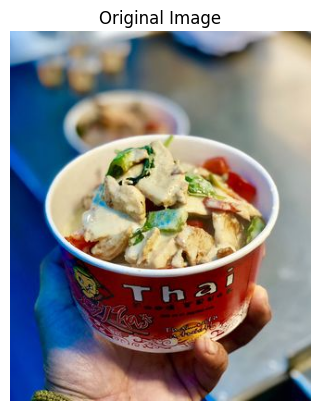

In [21]:
import cv2
from matplotlib import pyplot as plt
import os

# Define the path to the image
img_file = 'C:/Users/singh/Downloads/yelp_dataset/photos/__RMLkfCq_spMU1Q5TDHnA.jpg'

# Check if the file exists
if not os.path.isfile(img_file):
    print(f"Error: File does not exist at path: {img_file}")
else:
    # Read the image using OpenCV
    input_img = cv2.imread(img_file)

    # Check if the image was loaded successfully
    if input_img is None:
        print("Error: Image could not be loaded. Check the file format or OpenCV installation.")
    else:
        # Function to plot the image
        def show_image(image_data, image_title, color_map=None):
            if len(image_data.shape) == 2 or color_map is not None:
                plt.imshow(image_data, cmap=color_map)
            else:
                plt.imshow(image_data)
            plt.axis('off')  # Hide axis
            plt.title(image_title)
            plt.show()

        # Convert BGR to RGB for proper color display
        input_img_RGB = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

        # Plotting the original image
        show_image(input_img_RGB, "Original Image")


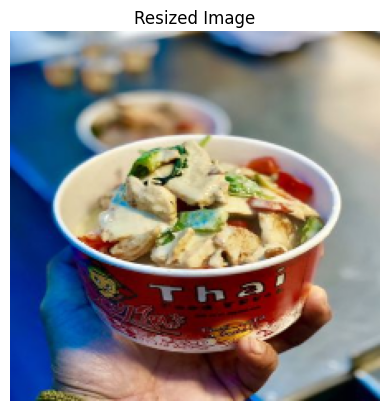

In [22]:
# plotting resize image
target_dim = (224, 224)
resized_photo = cv2.resize(input_img, target_dim)
resized_photo_rgb = cv2.cvtColor(resized_photo, cv2.COLOR_BGR2RGB)
show_image(resized_photo_rgb, "Resized Image")

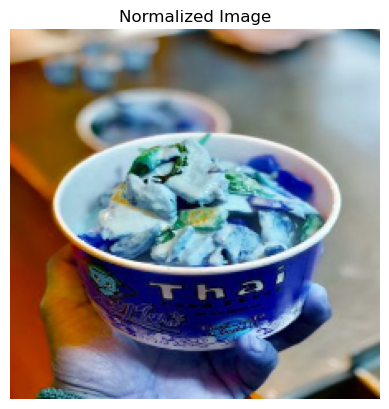

In [13]:
# plotting normalized image 
normalized_photo = resized_photo / 255.0
show_image(normalized_photo, "Normalized Image")

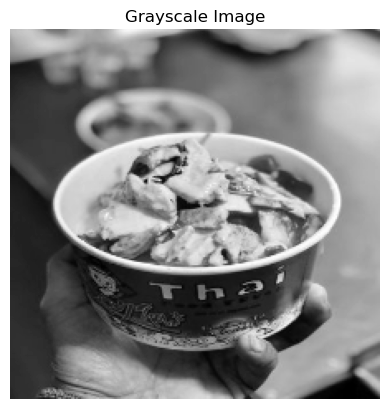

In [14]:
# converting image to grayscale and plotting it
grayscale_photo = cv2.cvtColor(resized_photo, cv2.COLOR_BGR2GRAY)
show_image(grayscale_photo, "Grayscale Image", color_map="gray")

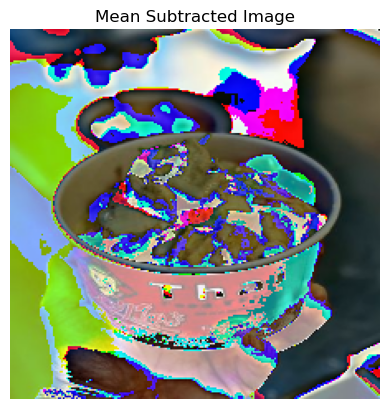

In [15]:
# plotting mean subtracted image 
pixel_mean = np.mean(resized_photo, axis=(0, 1)) 
mean_subtracted_photo = resized_photo - pixel_mean
mean_subtracted_photo = cv2.cvtColor(mean_subtracted_photo.astype(np.uint8), cv2.COLOR_BGR2RGB)
show_image(mean_subtracted_photo, "Mean Subtracted Image")

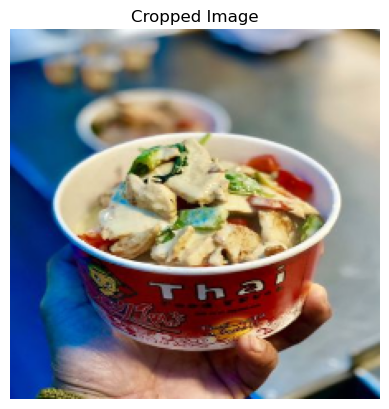

In [16]:
# plotting cropped image 
image_height, image_width = resized_photo.shape[:2]
crop_size = min(image_height, image_width)
crop_x = image_width // 2 - crop_size // 2
crop_y = image_height // 2 - crop_size // 2
cropped_photo = resized_photo[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]
cropped_photo_rgb = cv2.cvtColor(cropped_photo, cv2.COLOR_BGR2RGB)
show_image(cropped_photo_rgb, "Cropped Image")

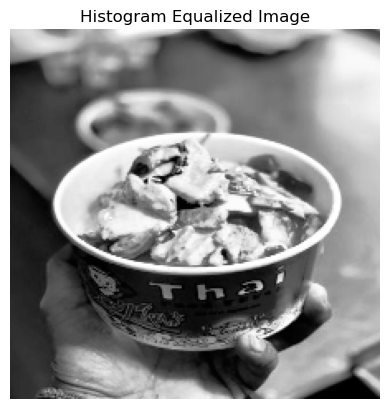

In [17]:
# plotting histogram equalized image
histogram_eq_photo = cv2.equalizeHist(grayscale_photo)
show_image(histogram_eq_photo, "Histogram Equalized Image", color_map="gray")

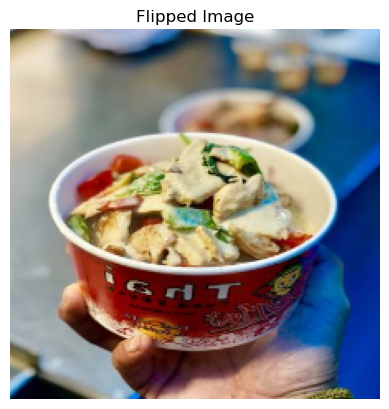

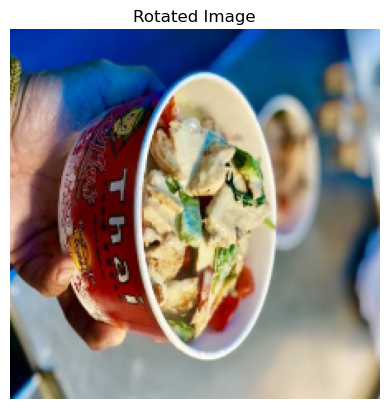

In [18]:
# data augmentation
flipped_photo = cv2.flip(resized_photo, 1)  
rotated_photo = cv2.rotate(resized_photo, cv2.ROTATE_90_CLOCKWISE)
flipped_photo_rgb = cv2.cvtColor(flipped_photo, cv2.COLOR_BGR2RGB)
rotated_photo_rgb = cv2.cvtColor(rotated_photo, cv2.COLOR_BGR2RGB)

# plotting augmented photos
show_image(flipped_photo_rgb, "Flipped Image")
show_image(rotated_photo_rgb, "Rotated Image")